# **Behavior Cloning**

## Install & Import packages/libraries

In [ ]:
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools > /dev/null 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install ipython==7.10.0 > /dev/null 2>&1
!pip install gymnasium[classic-control] > /dev/null 2>&1

In [ ]:
import gymnasium as gym
from gymnasium.wrappers.record_video import RecordVideo
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(
            HTML(
                data='''<video alt="test" autoplay loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                    </video>'''.format(encoded.decode('ascii'))
            )
        )
    else:
        print("Could not find video")

def wrap_env(env):#주어진 환경을 WRAP 하여 이미지로 저장하는 FUNCTION이다.
    env = RecordVideo(env, './video', disable_logger=True)
    return env

## MountainCar Visualization

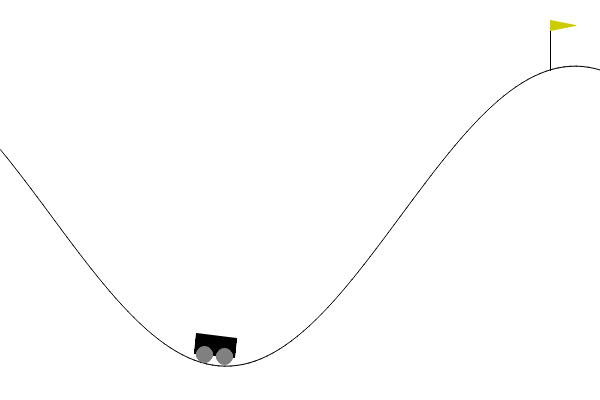

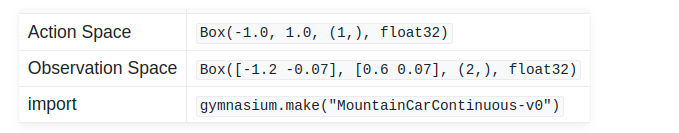

Information on "MountainCarContinuous-v0" gym environment: <br>
[github.com/openai/gym/wiki/MountainCarContinuous-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/)

In [ ]:
# Get environment information
env = gym.make("MountainCarContinuous-v0")
print("Observation Space:\t{}".format(env.observation_space))
print("Action Space:\t\t{}".format(env.action_space))
print("Reward Range:\t\t{}".format(env.reward_range))
print("Max Episode Steps:\t{}".format(env.spec.max_episode_steps))

Observation Space:	Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action Space:		Box(-1.0, 1.0, (1,), float32)
Reward Range:		(-inf, inf)
Max Episode Steps:	999


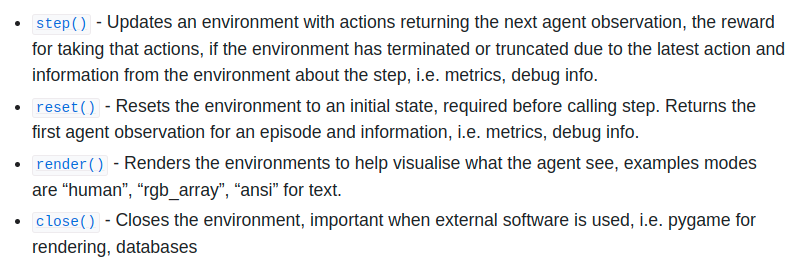
https://gymnasium.farama.org/api/env/

In [ ]:
import numpy as np

# Make environment
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")

# Wrap environment to enable rendering on google colab
env = wrap_env(env)

# Reset environment
obs, info = env.reset()

total_reward = 0
for t in range(1000):
    # Random action
    action = env.action_space.sample()
    # Uncomment to choose action from [-1.0, 1.0]
    # action = np.array([1.0])

    # Environment step
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward

    # Render environment to virtual display
    env.render()

    if terminated:
        print("Terminated. {} steps".format(t + 1))
        break

    if truncated:
        print("Truncated. {} steps".format(t + 1))
        break

# Close environment
env.close()

print('Total Reward: {:.2f}'.format(total_reward))
show_video()

/usr/local/lib/python3.9/dist-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Truncated. 999 steps
Total Reward: -32.24


## MountainCar Expert Behavior

Upload the given expert data "MountainCarContinuous-v0_expert.pkl"

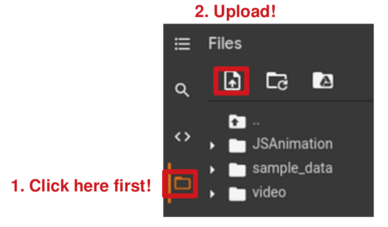

In [ ]:
import pickle
import numpy as np
from sklearn.utils import shuffle

# Load expert demonstrations
with open("./MountainCarContinuous-v0_expert_demo.pkl", 'rb') as f:
    demos = pickle.load(f)[0]

# Shuffle demonstrations
demos = shuffle(demos)

# Info
print("Number of expert demonstrations: {}".format(len(demos)))
print("Available information on each demonstration", list(demos[0].keys()))
print("Dimensions on components of first demonstration")
print("\tRewards: {}".format(demos[0]['rewards'].shape))
print("\tActions: {}".format(demos[0]['actions'].shape))
print("\tInfos: {}".format(len(demos[0]['infos'])))
print("\tObserves: {}".format(demos[0]['observes'].shape))

# Check expert's performance
exp_ret = np.mean([np.sum(d['rewards']) for d in demos])
print("Expert's Average Cumulative Rewards: {:.3f}".format(exp_ret))

Number of expert demonstrations: 100
Available information on each demonstration ['rewards', 'actions', 'infos', 'observes']
Dimensions on components of first demonstration
	Rewards: (276,)
	Actions: (276, 1)
	Infos: 276
	Observes: (276, 2)
Expert's Average Cumulative Rewards: 92.459


In [ ]:
# Gather the demonstrations' observations and actions
demo_observations = []
demo_actions = []
for demo in demos:
    for t_idx in range(len(demo['observes'])):
        demo_observations.append(demo['observes'][t_idx])
        demo_actions.append(demo['actions'][t_idx])

# Convert lists into numpy arrays
demo_observations = np.asarray(demo_observations)
demo_actions = np.asarray(demo_actions)

# Shuffle data to break correlation
demo_observations, demo_actions = shuffle(demo_observations, demo_actions)

# Check number of demonstrations!
print("Total number of demonstrations: {}".format(len(demo_actions)))

# Use only first 100 demos to avoid overload 가우시안을 너무 많은 데이터에 적용하면 계산량이 미친듯이 많아짐
demo_observations = demo_observations[:100, :]
demo_actions = demo_actions[:100, :]

# Print observation and action dimensions
print("Observation data: {}".format(demo_observations.shape))
print("Action data: {}".format(demo_actions.shape))

Total number of demonstrations: 41035
Observation data: (100, 2)
Action data: (100, 1)


## Gaussian Process Regression

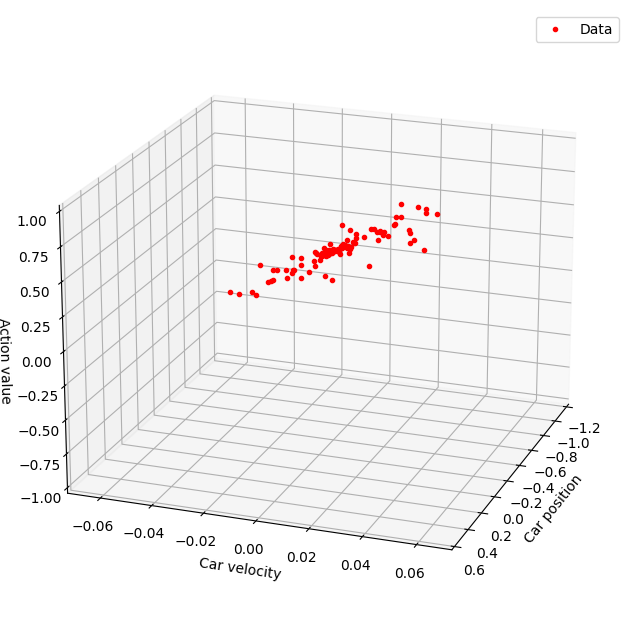

In [ ]:
# Visualize data points
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
x = demo_observations[:, 0] # position
y = demo_observations[:, 1] # velocity
z = demo_actions[:, 0] # actions value

def plot_3d(x, y, z, angle1=40, angle2=40):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    ax.plot3D(x, y, z, 'r.', label='Data')
    plt.legend()
    ax.set_xlabel('Car position')
    ax.set_ylabel('Car velocity')
    ax.set_zlabel('Action value')
    ax.set_xlim3d(-1.2, 0.6)
    ax.set_ylim3d(-0.07, 0.07)
    ax.set_zlim3d(-1., 1.) # action value space
    ax.view_init(angle1, angle2)
    plt.show()

plot_3d(x, y, z, 20, 20)

In [ ]:
# We will use GPR to learn from these expert demonstrations by setting them as targets!
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

# Hyperparameters (Tune at will)
init_lambda = 10.0
init_beta = 2.0
init_sigma = 0.04

# Initialize GPR
kernel = ConstantKernel(init_beta, (1e-3, 1e3)) * RBF(init_lambda, (1e-3, 1e3))
gp = GaussianProcessRegressor(kernel=kernel, alpha=init_sigma, n_restarts_optimizer=9)

# Normalize observations
# Remember, we offset values by the mean since we assume the Gaussian process has 0 mean! Here we also normalize by std values.

####### TO IMPLEMENT #########
demo_obs_mean = np.mean(demo_observations, axis=0, keepdims=True)
demo_obs_std = np.std(demo_observations, axis=0, keepdims=True)
nz_demo_observations = (demo_observations - demo_obs_mean)/demo_obs_std
##############################

# Fit GP
gp.fit(nz_demo_observations, demo_actions)

GaussianProcessRegressor(alpha=0.04, kernel=1.41**2 * RBF(length_scale=10),
                         n_restarts_optimizer=9)

In [ ]:
# Visualize learned GPR
def plot_GPR_3d(x, y, z, gp, mean, std, angle1=30, angle2=30, show_CI=True):
    x1 = np.linspace(-1.2, 0.6, 100).reshape(-1, 1)
    x2 = np.linspace(-0.07, 0.07, 100).reshape(-1, 1)
    X1, X2 = np.meshgrid(x1, x2)
    XX = np.concatenate([X1.reshape(-1, 1), X2.reshape(-1, 1)], axis=1)
    XX = (XX - mean) / std
    YY = np.zeros((100, 100))
    if show_CI is True:
        YY_upper = np.zeros((100, 100))
        YY_lower = np.zeros((100, 100))
    for i in range(100):
        for j in range(100):
            idx = i*100 + j
            YY_mean, YY_std = gp.predict(XX[idx].reshape(-1, 2), return_std=True)
            YY[i, j] += YY_mean
            if show_CI is True:
                YY_upper[i, j] += YY_mean + 1.96*YY_std
                YY_lower[i, j] += YY_mean - 1.96*YY_std
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    ax.plot3D(x, y, z, 'r.', label='Data')
    ax.plot_surface(X1, X2, YY)
    if show_CI is True:
        ax.plot_surface(X1, X2, YY_upper)
        ax.plot_surface(X1, X2, YY_lower)
    plt.legend()
    ax.set_xlabel('Car position')
    ax.set_ylabel('Car velocity')
    ax.set_zlabel('Action value')
    ax.set_xlim3d(-1.2, 0.6)
    ax.set_ylim3d(-0.07, 0.07)
    ax.set_zlim3d(-1., 1.) # action value space
    ax.view_init(angle1, angle2)
    plt.show()

plot_GPR_3d(x, y, z, gp, demo_obs_mean, demo_obs_std, 20, 20, show_CI=True)

NameError: ignored

In [ ]:
# Make environment
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")

# Wrap environment to enable rendering on google colab
env = wrap_env(env)

# Reset environment
obs, info = env.reset()

total_reward = 0
for t in range(10000):
    # Use GPR to determine actions
    obs = np.reshape(obs, [1, -1])
    ############# TO IMPLEMENT ################
    nz_obs = (obs-demo_obs_mean) / demo_obs_std
    action = gp.predict(nz_obs)
    ###########################################

    # Environment step
    obs, reward, terminated, truncated, info = env.step(action)
    total_reward += reward

    # Render environment to virtual display
    env.render()

    if terminated:
        print("Terminated. {} steps".format(t + 1))
        break

    if truncated:
        print("Truncated. {} steps".format(t + 1))
        break

# Close environment
env.close()

print('Total Reward: {:.2f}'.format(total_reward))
show_video()

/usr/local/lib/python3.9/dist-packages/gymnasium/wrappers/record_video.py:87: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Terminated. 286 steps
Total Reward: 93.99
